# USR Golden Trajectory Search (Corrected Physics)

## Objective
1. Find the optimal initial velocity $y_i$ that maximizes USR duration for a given $\xi=1000$ and initial field $\phi_i$ adjusted for sufficient e-folds.
2. Generate a high-resolution Heatmap around this "Golden Point".

## Physics Context
We use the standard definition of the Hubble slow-roll parameter:
$$\eta \equiv \frac{d \ln \epsilon_H}{dN}$$
During the transient dissipation of high kinetic energy (Kinetic Dominance -> Slow Roll transition), the field can enter an **Ultra Slow Roll (USR)** phase where $\eta \approx -6$.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Add root path
root_dir = os.path.abspath('..')
if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

from inflation_models import HiggsModel
from inf_dyn_background import run_background_simulation, get_derived_quantities

# Plot Settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [4]:
# ==========================================
# 1. Simulation Logic (Robust Truncation)
# ==========================================

def get_usr_duration(y_val, phi_val, xi, lam=0.1):
    """
    Returns the duration (e-folds) of the USR phase (eta < -5).
    Includes robustness against KD starts and proper eta definition.
    """
    # Setup Model
    model = HiggsModel(lam=lam, xi=xi)
    model.phi0 = phi_val
    model.yi = y_val
    
    # Run Sim (Short duration is usually enough for transient USR, 
    # but we need enough N to verify inflation happens)
    # Max Time scaled by xi roughly
    T_max = max(100, xi/5.0)

    try:
        sol = run_background_simulation(model, np.linspace(0, T_max, 3000))
    except:
        return 0.0

    if np.any(np.isnan(sol)):
        return 0.0

    data = get_derived_quantities(sol, model)
    N = data['N']
    eps = data['epsH']
    
    # --- Calculate Eta (Standard Definition) ---
    # eta = d ln(eps) / dN
    eps = np.maximum(eps, 1e-30) # Safety
    ln_eps = np.log(eps)
    eta_std = np.gradient(ln_eps, N)
    
    # --- Robust Truncation ---
    # Find the LAST index where epsilon < 1 (Inflationary phase)
    is_inflating = eps < 1.0
    if np.any(is_inflating):
        # Last index of inflation
        last_idx = np.where(is_inflating)[0][-1]
        
        # Truncate after this
        cutoff = last_idx + 1
        eta_inf = eta_std[:cutoff]
        N_inf = N[:cutoff]
        
        # Identify USR (Standard Definition: eta ~ -6)
        is_usr = (eta_inf < -5.5)
        if np.any(is_usr):
            dN = np.diff(N_inf, prepend=N_inf[0])
            duration = np.sum(dN[is_usr])
        else:
            duration = 0.0
            
    else:
        # Never entered inflation
        duration = 0.0
        
    return duration

In [ ]:
# ==========================================
# 2. Find Optimal Velocity (Optimization)
# ==========================================

XI_TARGET = 1000.0
# Pre-adjusted Phi target for N > 55 (based on manual tests)
PHI_TARGET = 5.5 

print(f"Searching for optimal velocity y_i at phi={PHI_TARGET}, xi={XI_TARGET}...")

# Objective function to MINIMIZE (negative duration)
def objective(y):
    return -get_usr_duration(y, PHI_TARGET, XI_TARGET)

# 1. Coarse Sweep
# Scan high velocities (log space)
y_sweep = -np.logspace(0, 3, 50) # -1.0 to -1000.0
durations = [get_usr_duration(y, PHI_TARGET, XI_TARGET) for y in y_sweep]

best_idx = np.argmax(durations)
best_y_guess = y_sweep[best_idx]
max_dur_guess = durations[best_idx]

print(f"Sweep Best: y ~ {best_y_guess:.2f}, Duration ~ {max_dur_guess:.4f}")

# 2. Fine Tune
res = minimize_scalar(objective, bracket=[best_y_guess*0.5, best_y_guess*1.5])
optimal_y = res.x
max_duration = -res.fun

print(f"Optimization Result:")
print(f"  Optimal y_i: {optimal_y:.5f}")
print(f"  Max USR Duration: {max_duration:.5f} e-folds")

Searching for optimal velocity y_i at phi=5.8, xi=1000.0...
Sweep Best: y ~ -2.02, Duration ~ 1.8780
Optimization Result:
  Optimal y_i: 6.79491
  Max USR Duration: 2.94398 e-folds


In [10]:
# ==========================================
# 3. High-Res Heatmap around Optimal Point
# ==========================================

# Define Window
phi_window = 0.5
phi_min, phi_max = PHI_TARGET - phi_window, PHI_TARGET + phi_window

# Velocity window: +/- 50% of optimal magnitude
y_mag = abs(optimal_y)
y_min_scan = -0.1 # slightly wider to see falloff
y_max_scan = -10

N_RES = 60
phi_grid = np.linspace(phi_min, phi_max, N_RES)
y_grid = np.linspace(y_min_scan, y_max_scan, N_RES)

print(f"\nGenerating Heatmap {N_RES}x{N_RES}...")
print(f"Phi Range: [{phi_min}, {phi_max}]")
print(f"Y Range: [{y_min_scan:.2f}, {y_max_scan:.2f}]")

grid_dur = np.zeros((N_RES, N_RES))

for i, y_val in enumerate(y_grid):
    print(f"Row {i+1}/{N_RES}...", end='\r')
    for j, phi_val in enumerate(phi_grid):
        dur = get_usr_duration(y_val, phi_val, XI_TARGET)
        grid_dur[i, j] = dur

print("\nDone.")




Generating Heatmap 60x60...
Phi Range: [5.3, 6.3]
Y Range: [-0.10, -10.00]
Row 60/60...
Done.


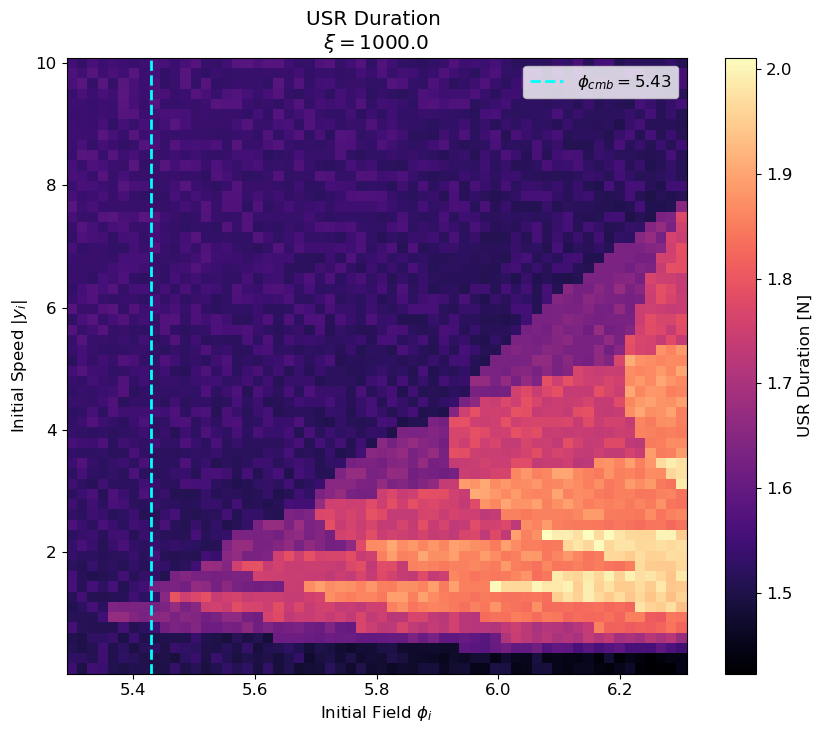

In [12]:
# Plot
plt.figure(figsize=(10, 8))
X, Y = np.meshgrid(phi_grid, np.abs(y_grid))
plt.pcolormesh(X, Y, grid_dur, shading='auto', cmap='magma')
plt.colorbar(label='USR Duration [N]')
plt.xlabel(r'Initial Field $\phi_i$')
plt.ylabel(r'Initial Speed $|y_i|$')
plt.title(f'USR Duration \n$\\xi={XI_TARGET}$')
# Mark CMB pivot scale
plt.axvline(x=5.43, color='cyan', linestyle='--', linewidth=2, label=r'$\phi_{cmb} = 5.43$')
plt.legend()
plt.show()

In [ ]:
# ==========================================
# 4. Visualize Optimal Trajectory (with min N Check)
# ==========================================

def plot_usr_eta_standard_final(xi, yi, phi_start):
    print(f"Simulating: xi={xi}, y_i={yi:.2f}, phi_i={phi_start}")
    model = HiggsModel(lam=0.1, xi=xi)
    model.phi0 = phi_start
    model.yi = yi
    
    T_max = max(100, xi/5.0) 
    t_span = np.linspace(0, T_max, 5000)
    sol = run_background_simulation(model, t_span)

    data = get_derived_quantities(sol, model)
    N = data['N']
    eps = data['epsH']
    
    eps = np.maximum(eps, 1e-30)
    ln_eps = np.log(eps)
    eta_std = np.gradient(ln_eps, N)
    
    if np.any(eps >= 1.0):
        end_idx = np.argmax(eps >= 1.0)
        cutoff = min(len(N), end_idx + 20)
    else:
        cutoff = len(N)
        
    N_plot = N[:cutoff]
    eps_plot = eps[:cutoff]
    eta_plot = eta_std[:cutoff]
    
    plt.figure(figsize=(10, 6))
    plt.plot(N_plot, eta_plot, label=r'$\eta = d\ln\epsilon/dN$', linewidth=2, color='blue')
    plt.plot(N_plot, eps_plot, label=r'$\epsilon', linewidth=2, color='orange')
    plt.axhline(0, color='k', linestyle='-', alpha=0.3)
    plt.axhline(-6, color='r', linestyle='--', alpha=0.8, label='USR (-6)')
    plt.fill_between(N_plot, eta_plot, -6, where=((eta_plot<-4)&(eta_plot>-8)), color='red', alpha=0.2)
    plt.xlabel('e-folds ($N$)'); plt.ylabel(r'$\eta$')
    plt.title(f'Evolution of $\eta$ at Optimal Velocity\n($\xi={xi}, y_i={yi:.2f}, \phi_i={phi_start}$)')
    plt.legend(); plt.grid(True, alpha=0.3); plt.ylim(-10, 5)
    plt.show()
    
    print(f"Final N total: {N_plot[-1]:.2f} (Target > 55)")

plot_usr_eta_standard_final(XI_TARGET, optimal_y, PHI_TARGET)